# Spotify song recommendation system

Spotify is the most popular music streaming service. They also have a public API with lots of features per track that you can use to analyze the songs. In this report I've used the public API and two different datasets I've come across on Kaggle. I tried with a second dataset containing the genres of the songs since I felt that the results were somewhat over the place even though the features would suggest they sound the same.

In [180]:
import pandas as pd
import numpy as np
import re
import itertools
import numbers
import time

from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer

import matplotlib.pyplot as plt
import seaborn as sns

#### Load first dataset

In [181]:
tracks_df = pd.read_csv('tracks.csv')

In [182]:
tracks_df.head()

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,35iwgR4jXetI318WEWsa1Q,Carve,6,126903,0,['Uli'],['45tIt06XoI0Iio4LBEVpls'],1922-02-22,0.645,0.4450,0,-13.338,1,0.4510,0.674,0.7440,0.151,0.127,104.851,3
1,021ht4sdgPcrDgSk7JTbKY,Capítulo 2.16 - Banquero Anarquista,0,98200,0,['Fernando Pessoa'],['14jtPCOoNZwquk5wd9DxrY'],1922-06-01,0.695,0.2630,0,-22.136,1,0.9570,0.797,0.0000,0.148,0.655,102.009,1
2,07A5yehtSnoedViJAZkNnc,Vivo para Quererte - Remasterizado,0,181640,0,['Ignacio Corsini'],['5LiOoJbxVSAMkBS2fUm3X2'],1922-03-21,0.434,0.1770,1,-21.180,1,0.0512,0.994,0.0218,0.212,0.457,130.418,5
3,08FmqUhxtyLTn6pAh6bk45,El Prisionero - Remasterizado,0,176907,0,['Ignacio Corsini'],['5LiOoJbxVSAMkBS2fUm3X2'],1922-03-21,0.321,0.0946,7,-27.961,1,0.0504,0.995,0.9180,0.104,0.397,169.980,3
4,08y9GfoqCWfOGsKdwojr5e,Lady of the Evening,0,163080,0,['Dick Haymes'],['3BiJGZsyX9sJchTqcSA7Su'],1922,0.402,0.1580,3,-16.900,0,0.0390,0.989,0.1300,0.311,0.196,103.220,4


In [183]:
tracks_df.shape

(586672, 20)

### Description of variables:
* ID: The Spotify ID of the track
* Popularity: Range of 0-100 where 100 is the most popular.
* Danceability: describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.
* Energy: is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.
* Key: the key the track is in. Integers map to pitches using standard Pitch Class notation. E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on. If no key was detected, the value is -1.
* Loudness: the overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typically range between -60 and 0 db.
* Mode: Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0.
* Speechiness: detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks.
* Acousticness: a confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.
* Instrumentalness: predicts whether a track contains no vocals. "Ooh" and "aah" sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly "vocal". The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0.
* Liveness: detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live.
* Valence: a measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).
* Tempo: the overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration.
* Time Signature: An estimated overall time signature of a track. The time signature (meter) is a notational convention to specify how many beats are in each bar (or measure).

In [184]:
tracks_df.isnull().sum()

id                   0
name                71
popularity           0
duration_ms          0
explicit             0
artists              0
id_artists           0
release_date         0
danceability         0
energy               0
key                  0
loudness             0
mode                 0
speechiness          0
acousticness         0
instrumentalness     0
liveness             0
valence              0
tempo                0
time_signature       0
dtype: int64

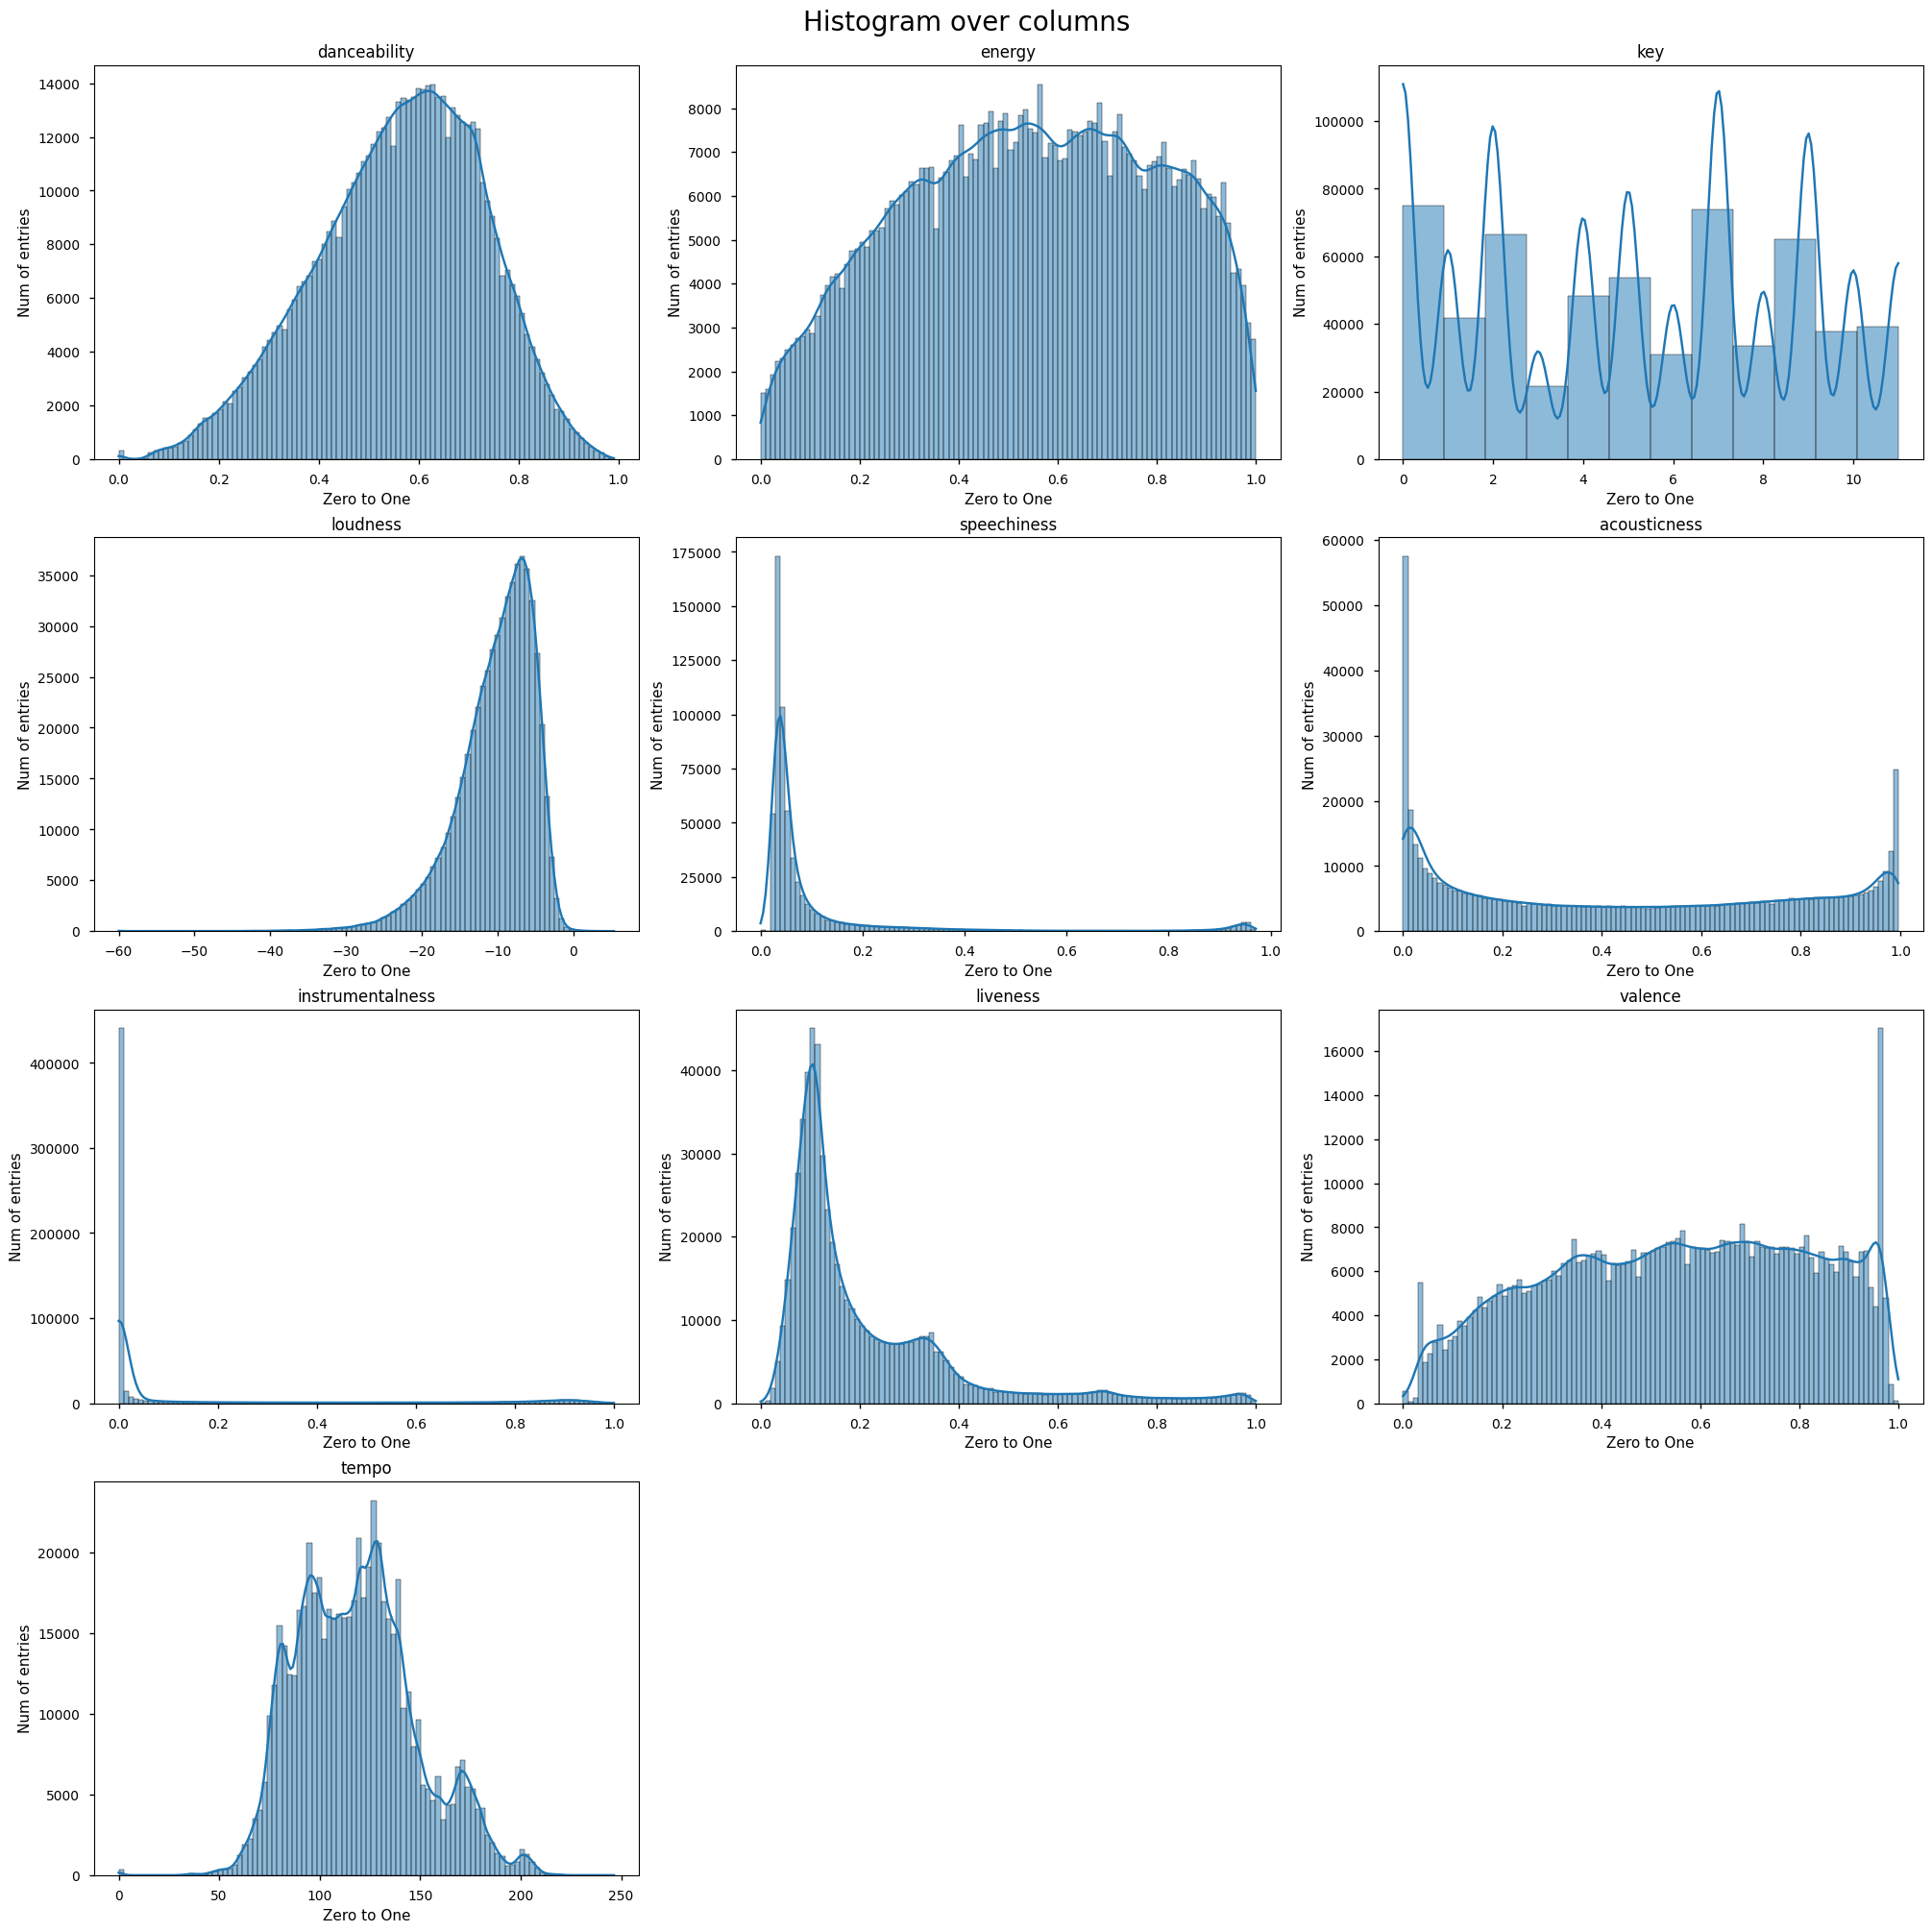

In [185]:
ds_histograms = tracks_df[['danceability', 'energy', 'key', 'loudness', 'speechiness', 'acousticness','instrumentalness', 'liveness', 'valence', 'tempo']] 

fig1 = plt.figure(1, figsize=(20, 20), layout='constrained') # unique id, width/height in inches, tighter layout
plt.suptitle("Histogram over columns", fontsize=20)

for i in range(ds_histograms.shape[1]):
    plt.subplot(4, 3, i + 1) # Number of rows, number of cols, index in subplot
    
    f = plt.gca() # Get the current Axes
    f.set_title(ds_histograms.columns.values[i]) # Set title to column value
    plt.xlabel("Zero to One") 
    plt.ylabel("Num of entries")
    
    vals = np.size(ds_histograms.iloc[:, i].unique()) # Get the size of the column values
    if vals >= 100:
        vals = 100
    plt.style.use('seaborn-v0_8-notebook') # Used plt.style.available and just picked one, for fun :)
    #plt.hist(ds_histograms.iloc[:, i], bins=vals)
    sns.histplot(ds_histograms.iloc[:, i], bins=vals, kde=True)

In [186]:
null_rows = tracks_df[tracks_df['name'].isnull()]
print(null_rows)

                            id name  popularity  duration_ms  explicit   
226336  4iH7negBYMfj2z0wDNmgdx  NaN          28       264973         0  \
510975  04d5kbLvSAIBt3pGcljdhC  NaN           0       184293         0   
510976  05tRkgyxVdwMePGqOXMDYU  NaN           0       191587         0   
510978  0YAMRgAQH6tkTh4sWNXr8L  NaN           0       191573         0   
510979  1K6MQQxmFpPb66ZnaiIpHX  NaN           0       167602         0   
...                        ...  ...         ...          ...       ...   
517206  6OH9mz9aFbGlbf74cBwYWD  NaN           2       209760         0   
517215  15RqFDA86slfzujSQMEX4i  NaN           2       257280         0   
520127  0hKA9A2JPtFdg0fiMhyjQD  NaN           6       194081         0   
525238  1kR4gIb7nGxHPI3D2ifs59  NaN          26       289440         0   
525265  4xyBq8t4nkUKH8s28j6ZoD  NaN          24       254000         0   

       artists                  id_artists release_date  danceability  energy   
226336    ['']  ['0LyfQWJT6nXa

In [187]:
tracks_df = tracks_df.dropna(subset=['name'])

In [188]:
tracks_df.isnull().sum()

id                  0
name                0
popularity          0
duration_ms         0
explicit            0
artists             0
id_artists          0
release_date        0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
time_signature      0
dtype: int64

#### Load second dataset

In [189]:
artists_df = pd.read_csv('artists.csv')

In [190]:
artists_df.head()

,id,followers,genres,name,popularity
0,0DheY5irMjBUeLybbCUEZ2,0.0,[],Armid & Amir Zare Pashai feat. Sara Rouzbehani,0
1,0DlhY15l3wsrnlfGio2bjU,5.0,[],ปูนา ภาวิณี,0
2,0DmRESX2JknGPQyO15yxg7,0.0,[],Sadaa,0
3,0DmhnbHjm1qw6NCYPeZNgJ,0.0,[],Tra'gruda,0
4,0Dn11fWM7vHQ3rinvWEl4E,2.0,[],Ioannis Panoutsopoulos,0


#### Cleaning up/removing brackets

In [191]:
artists_df['genres'].values[1002]

"['german reggae']"

In [192]:
artists_df['genres'].values[1002][0]

'['

In [193]:
artists_df['genres_upd'] = artists_df['genres'].apply(lambda x: [re.sub(' ','_',i) for i in re.findall(r"'([^']*)'", x)])

In [194]:
artists_df['genres_upd'].values[1002][0]

'german_reggae'

In [195]:
artists_df.sample(100)

,id,followers,genres,name,popularity,genres_upd
816881,2rNEo2yMaMr62WFaJWMuqu,347.0,[],Malice Divine,11,[]
232058,1SC79Ei8hqkxx6avagiBo0,1.0,[],パタリロ、タマネギ部隊、魔夜メンズ(舞台「パタリロ!」★スターダスト計画★より),0,[]
734065,6Mhzt8Vf0WmimfSrZpqQZo,59.0,[],Marc Regnier,6,[]
96262,5TFAleOJ7VJt3yieCFy8J8,6870.0,"['dark trap', 'phonk']",Lil Kaine,43,"[dark_trap, phonk]"
855114,4F6qRDDgit8zxFukXbUsg9,58.0,['melodic power metal'],Sledge Leather,0,[melodic_power_metal]
...,...,...,...,...,...,...
872326,1UjhIr75r6tYCzwRLBBHqQ,33.0,['portland hip hop'],Lang,1,[portland_hip_hop]
154575,3LiuOqKmyvomCURiZaM16Q,24.0,[],Bayou Liberty Jazz Band,0,[]
613621,3xokCyPKlaUw8wXUG6rq4N,57.0,[],Projetamente,0,[]
942980,63p2Ne533lKurOHMZ9hPUK,49.0,[],Equator,1,[]


In [196]:
tracks_df['artists_upd_v1'] = tracks_df['artists'].apply(lambda x: re.findall(r"'([^']*)'", x))

In [197]:
tracks_df['artists'].values[0]

"['Uli']"

In [198]:
tracks_df['artists_upd_v1'].values[0][0]

'Uli'

In [199]:
tracks_df[tracks_df['artists_upd_v1'].apply(lambda x: not x)].head(5)

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,artists_upd_v1
164,1xEEYhWxT4WhDQdxfPCT8D,Snake Rag,20,194533,0,"[""King Oliver's Creole Jazz Band""]",['08Zk65toyJllap1MnzljxZ'],1923,0.708,0.361,...,-11.764,0,0.0441,0.994,0.883,0.103,0.902,105.695,4,[]
170,3rauXVLOOM5BlxWqUcDpkg,Chimes Blues,14,170827,0,"[""King Oliver's Creole Jazz Band""]",['08Zk65toyJllap1MnzljxZ'],1923,0.546,0.189,...,-15.984,1,0.0581,0.996,0.908,0.339,0.554,80.318,4,[]
172,1UdqHVRFYMZKU2Q7xkLtYc,Pickin' On Your Baby,11,197493,0,"[""Clarence Williams' Blue Five""]",['6RuQvIr0t0otZHnAxXTGkm'],1923,0.520,0.153,...,-14.042,1,0.0440,0.995,0.131,0.353,0.319,102.937,4,[]
174,0Vl2DO5U6FjgBpzCtBN3OA,Everybody Loves My Baby,10,152507,0,"[""Clarence Williams' Blue Five""]",['6RuQvIr0t0otZHnAxXTGkm'],1923,0.514,0.193,...,-13.920,0,0.2380,0.996,0.199,0.248,0.665,180.674,4,[]
180,5SvyP1ZeJX1jA7AOZD08NA,Tears,10,187227,0,"[""King Oliver's Creole Jazz Band""]",['08Zk65toyJllap1MnzljxZ'],1923,0.359,0.357,...,-11.810,1,0.0511,0.994,0.819,0.290,0.753,205.053,4,[]


In [200]:
# Convert dates to datetime objects, coerce = if the conversion does not work it will be set to NaT (Not a Time)
tracks_df['release_date'] = pd.to_datetime(tracks_df['release_date'], errors='coerce')

# Drop rows with 'release_date' under 1960
tracks_df = tracks_df[tracks_df['release_date'].dt.year >= 1964]

# Reset the index
tracks_df = tracks_df.reset_index(drop=True)

In [201]:
# Cleaning up the brackets and handling of tracks with multiple artists. For example, if the 'artists' column contains the string '["Artist 1", "Artist 2"]', this line would extract 'Artist 1' and 'Artist 2' and store them as a list in the 'artists_upd_v2' column.
tracks_df['artists_upd_v2'] = tracks_df['artists'].apply(lambda x: re.findall('\"(.*?)\"',x))
tracks_df['artists_upd'] = np.where(tracks_df['artists_upd_v1'].apply(lambda x: not x), tracks_df['artists_upd_v2'], tracks_df['artists_upd_v1'] )

In [202]:
tracks_df[tracks_df['artists_upd_v1'].apply(lambda x: not x)].head(5)

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,...,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,artists_upd_v1,artists_upd_v2,artists_upd
415,6oCdV6oW0gLQxHlrGOomxp,Abusadora,28,204280,0,"[""Billo's""]",['38zyliF0xdJKS7k1BIEuL6'],1964-07-17,0.703,0.571,...,0.0406,0.274,0.00000,0.0578,0.925,131.091,4,[],[Billo's],[Billo's]
421,1I0erMteTQwwtDaqzwuQI0,He's in Town,28,159227,0,"[""The Rockin' Berries""]",['6G18NLfr5luyGYgMKIupm3'],1964-01-01,0.428,0.546,...,0.0329,0.579,0.00000,0.1220,0.469,107.651,4,[],[The Rockin' Berries],[The Rockin' Berries]
699,51bylzFSkrMp9kwmMtzN2X,The End of the World - 1997 Remaster,50,180227,0,"[""Herman's Hermits""]",['48YxSlb23RAaCd4RyHcV9V'],1965-01-01,0.429,0.257,...,0.0280,0.864,0.00154,0.0878,0.382,90.004,3,[],[Herman's Hermits],[Herman's Hermits]
844,6C4iMi6YSLjmZ8GFqEsrby,Mrs Brown You've Got a Lovely Daughter - 1997 ...,39,165267,0,"[""Herman's Hermits""]",['48YxSlb23RAaCd4RyHcV9V'],1965-01-01,0.638,0.470,...,0.0601,0.673,0.00704,0.0912,0.921,149.364,4,[],[Herman's Hermits],[Herman's Hermits]
1448,0krGrryTVif71gYlmkJBoI,No Milk Today,5,173573,0,"[""Herman's Hermits""]",['48YxSlb23RAaCd4RyHcV9V'],2020-03-13,0.660,0.529,...,0.0298,0.356,0.00000,0.0641,0.953,133.780,4,[],[Herman's Hermits],[Herman's Hermits]


In [203]:
artists_exploded = tracks_df[['artists_upd','id']].explode('artists_upd')

In [204]:
artists_exploded_enriched = artists_exploded.merge(artists_df, how = 'left', left_on = 'artists_upd',right_on = 'name')

In [205]:
artists_exploded_enriched.head()

,artists_upd,id_x,id_y,followers,genres,name,popularity,genres_upd
0,Simon & Garfunkel,5y788ya4NvwhBznoDIcXwK,70cRZdQywnSFp9pnc2WTCE,3354252.0,"['classic rock', 'folk', 'folk rock', 'melanch...",Simon & Garfunkel,76.0,"[classic_rock, folk, folk_rock, melancholia, m..."
1,The Kinks,29SyMC0plk6qw8NMF7lfRL,1SQRv42e4PjEYfPhS0Tk9E,1834896.0,"['album rock', 'art rock', 'british invasion',...",The Kinks,71.0,"[album_rock, art_rock, british_invasion, class..."
2,Chuck Berry,6FT83pFXKhDlXDsNJFAHWz,293zczrfYafIItmnmM3coR,1367891.0,"['adult standards', 'blues rock', 'classic roc...",Chuck Berry,69.0,"[adult_standards, blues_rock, classic_rock, ro..."
3,The Drifters,65jrjEhWfAvysKfnojk1i0,01OBi5Y7ohTV6I7elKdENg,0.0,[],The Drifters,0.0,[]
4,The Drifters,65jrjEhWfAvysKfnojk1i0,1FqqOl9itIUpXr4jZPIVoT,344925.0,"['adult standards', 'brill building pop', 'bub...",The Drifters,64.0,"[adult_standards, brill_building_pop, bubblegu..."


In [206]:
artists_genres_consolidated = artists_exploded_enriched.groupby('id_x')['genres_upd'].apply(list).reset_index()

In [207]:
# Drop rows with NaN values in the 'genres_upd' column
artists_genres_consolidated = artists_genres_consolidated.dropna(subset=['genres_upd'])

# Apply the lambda function to create the 'consolidates_genre_lists' column
artists_genres_consolidated['consolidates_genre_lists'] = artists_genres_consolidated['genres_upd'].apply(
    lambda x: list(set(list(itertools.chain.from_iterable(x)))) if (isinstance(x, list) and all(isinstance(item, str) for item in x)) else x
)

In [208]:
renamed_df = artists_genres_consolidated.rename(columns={'id_x': 'id'})

In [209]:
renamed_df.head()

,id,genres_upd,consolidates_genre_lists
0,0004Uy71ku11n3LMpuyf59,[[polish_rock]],[[polish_rock]]
1,000CSYu4rvd8cQ7JilfxhZ,"[[country_quebecois, rock_quebecois]]","[[country_quebecois, rock_quebecois]]"
2,000DsoWJKHdaUmhgcnpr8j,[[barnmusik]],[[barnmusik]]
3,000G1xMMuwxNHmwVsBdtj1,"[[candy_pop, new_wave, new_wave_pop, permanent...","[[candy_pop, new_wave, new_wave_pop, permanent..."
4,000KblXP5csWFFFsD6smOy,"[[chamame, folclore_salteno, folklore_argentino]]","[[chamame, folclore_salteno, folklore_argentino]]"


In [210]:
tracks_df.head()

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,...,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,artists_upd_v1,artists_upd_v2,artists_upd
0,5y788ya4NvwhBznoDIcXwK,The Sound of Silence - Acoustic Version,75,185413,0,['Simon & Garfunkel'],['70cRZdQywnSFp9pnc2WTCE'],1964-10-19,0.525,0.216,...,0.0301,0.837,0.000000,0.1070,0.328,106.761,4,[Simon & Garfunkel],[],[Simon & Garfunkel]
1,29SyMC0plk6qw8NMF7lfRL,You Really Got Me - Mono Mix,73,134253,0,['The Kinks'],['1SQRv42e4PjEYfPhS0Tk9E'],1964-10-02,0.573,0.939,...,0.0808,0.493,0.000000,0.0994,0.963,137.382,4,[The Kinks],[],[The Kinks]
2,6FT83pFXKhDlXDsNJFAHWz,You Never Can Tell,71,161907,0,['Chuck Berry'],['293zczrfYafIItmnmM3coR'],1964-11-01,0.525,0.852,...,0.2220,0.731,0.000051,0.2180,0.884,157.404,4,[Chuck Berry],[],[Chuck Berry]
3,65jrjEhWfAvysKfnojk1i0,Under the Boardwalk,70,161960,0,['The Drifters'],['1FqqOl9itIUpXr4jZPIVoT'],1964-06-01,0.747,0.226,...,0.0415,0.908,0.000168,0.1070,0.778,123.789,4,[The Drifters],[],[The Drifters]
4,0KOE1hat4SIer491XKk4Pa,A Change Is Gonna Come,70,191160,0,['Sam Cooke'],['6hnWRPzGGKiapVX1UCdEAC'],1964-03-01,0.212,0.383,...,0.0347,0.723,0.000000,0.2990,0.452,173.790,3,[Sam Cooke],[],[Sam Cooke]


#### Merging of the two datasets

In [211]:
tracks_df = tracks_df.merge(renamed_df[['id', 'genres_upd']], on='id', how='left')

In [212]:
tracks_df.head()

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,...,acousticness,instrumentalness,liveness,valence,tempo,time_signature,artists_upd_v1,artists_upd_v2,artists_upd,genres_upd
0,5y788ya4NvwhBznoDIcXwK,The Sound of Silence - Acoustic Version,75,185413,0,['Simon & Garfunkel'],['70cRZdQywnSFp9pnc2WTCE'],1964-10-19,0.525,0.216,...,0.837,0.000000,0.1070,0.328,106.761,4,[Simon & Garfunkel],[],[Simon & Garfunkel],"[[classic_rock, folk, folk_rock, melancholia, ..."
1,29SyMC0plk6qw8NMF7lfRL,You Really Got Me - Mono Mix,73,134253,0,['The Kinks'],['1SQRv42e4PjEYfPhS0Tk9E'],1964-10-02,0.573,0.939,...,0.493,0.000000,0.0994,0.963,137.382,4,[The Kinks],[],[The Kinks],"[[album_rock, art_rock, british_invasion, clas..."
2,6FT83pFXKhDlXDsNJFAHWz,You Never Can Tell,71,161907,0,['Chuck Berry'],['293zczrfYafIItmnmM3coR'],1964-11-01,0.525,0.852,...,0.731,0.000051,0.2180,0.884,157.404,4,[Chuck Berry],[],[Chuck Berry],"[[adult_standards, blues_rock, classic_rock, r..."
3,65jrjEhWfAvysKfnojk1i0,Under the Boardwalk,70,161960,0,['The Drifters'],['1FqqOl9itIUpXr4jZPIVoT'],1964-06-01,0.747,0.226,...,0.908,0.000168,0.1070,0.778,123.789,4,[The Drifters],[],[The Drifters],"[[], [adult_standards, brill_building_pop, bub..."
4,0KOE1hat4SIer491XKk4Pa,A Change Is Gonna Come,70,191160,0,['Sam Cooke'],['6hnWRPzGGKiapVX1UCdEAC'],1964-03-01,0.212,0.383,...,0.723,0.000000,0.2990,0.452,173.790,3,[Sam Cooke],[],[Sam Cooke],"[[adult_standards, brill_building_pop, classic..."


In [213]:
float_cols = tracks_df.dtypes[tracks_df.dtypes == 'float64'].index.values
print(f"Float cols: {float_cols}")

Float cols: ['danceability' 'energy' 'loudness' 'speechiness' 'acousticness'
 'instrumentalness' 'liveness' 'valence' 'tempo']


In [214]:
float_cols = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness',
 'instrumentalness', 'liveness', 'valence', 'tempo', 'popularity']

In [215]:
def create_feature_set(df, float_cols):
    """
    Creates a feature set for the given DataFrame.

    Args:
        df: The DataFrame to create the feature set for.
        float_cols: A list of the float columns to include in the feature set.

    Returns:
        A DataFrame containing the feature set.
    """

    # Convert genre lists to strings
    import ast

    def convert_to_string(x):
        if isinstance(x, list):
            return str([item for sublist in x for item in sublist]) if x else '[]'
        elif isinstance(x, str):
            return x
        else:
            return ast.literal_eval(x)

    df['genres_upd'] = df['genres_upd'].astype(str)
    df['genres_upd'] = df['genres_upd'].apply(lambda x: convert_to_string(x))

    # Define features
    features = float_cols + ['id', 'genres_upd']

    # Create feature set
    feature_set = df[features]

    return feature_set


In [216]:
# Example usage
feature_set = create_feature_set(tracks_df, float_cols)
print(feature_set.head())
print(feature_set.shape)
print(feature_set.duplicated().sum())
print(feature_set.columns.tolist())



   danceability  energy  loudness  speechiness  acousticness   
0         0.525   0.216   -13.551       0.0301         0.837  \
1         0.573   0.939    -6.441       0.0808         0.493   
2         0.525   0.852    -9.519       0.2220         0.731   
3         0.747   0.226   -13.635       0.0415         0.908   
4         0.212   0.383   -10.071       0.0347         0.723   

   instrumentalness  liveness  valence    tempo  popularity   
0          0.000000    0.1070    0.328  106.761          75  \
1          0.000000    0.0994    0.963  137.382          73   
2          0.000051    0.2180    0.884  157.404          71   
3          0.000168    0.1070    0.778  123.789          70   
4          0.000000    0.2990    0.452  173.790          70   

                       id                                         genres_upd  
0  5y788ya4NvwhBznoDIcXwK  [['classic_rock', 'folk', 'folk_rock', 'melanc...  
1  29SyMC0plk6qw8NMF7lfRL  [['album_rock', 'art_rock', 'british_invasion'...  

In [217]:
# Convert the 'genres_upd' column to a string
feature_set.loc[:, 'genres_upd'] = feature_set['genres_upd'].astype(str)

# Create a CountVectorizer object
vectorizer = CountVectorizer()

# Fit and transform the vectorizer on the 'genres_upd' column
genres_matrix = vectorizer.fit_transform(feature_set['genres_upd'])

# Create a DataFrame from the genres_matrix
genres_df = pd.DataFrame(genres_matrix.toarray(), columns=vectorizer.get_feature_names_out())

# Use .loc to set values on the original DataFrame
feature_set.loc[:, 'genres_upd'] = feature_set['genres_upd'].astype(str)

# Concatenate the new DataFrame with the original feature_set
feature_set_with_genres = pd.concat([feature_set, genres_df], axis=1)

# Drop the original 'genres_upd' column if needed
feature_set_with_genres = feature_set_with_genres.drop(columns=['genres_upd'])

# Print the resulting DataFrame
print(feature_set_with_genres.head())

   danceability  energy  loudness  speechiness  acousticness   
0         0.525   0.216   -13.551       0.0301         0.837  \
1         0.573   0.939    -6.441       0.0808         0.493   
2         0.525   0.852    -9.519       0.2220         0.731   
3         0.747   0.226   -13.635       0.0415         0.908   
4         0.212   0.383   -10.071       0.0347         0.723   

   instrumentalness  liveness  valence    tempo  popularity  ... zim_hip_hop   
0          0.000000    0.1070    0.328  106.761          75  ...           0  \
1          0.000000    0.0994    0.963  137.382          73  ...           0   
2          0.000051    0.2180    0.884  157.404          71  ...           0   
3          0.000168    0.1070    0.778  123.789          70  ...           0   
4          0.000000    0.2990    0.452  173.790          70  ...           0   

   zim_urban_groove  zimdancehall  zither  zolo  zouglou  zouk  zouk_riddim   
0                 0             0       0     0        

#### MinMaxScaler
Ensuring that the values are scaled properly - for example if one column has data that ranges from 0-100 and another ranges from 10-25, they all range from 0-1 instead. This helps preventing feautures with large ranges from dominating the results.

In [218]:
# Select the columns to be scaled
columns_to_scale = ['danceability', 'energy', 'loudness', 'speechiness',
                    'acousticness', 'instrumentalness', 'liveness',
                    'valence', 'tempo', 'popularity']

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Fit the scaler on the selected columns and transform the data
feature_set_with_genres[columns_to_scale] = scaler.fit_transform(feature_set_with_genres[columns_to_scale])

In [219]:
print(feature_set_with_genres.dtypes)

danceability    float64
energy          float64
loudness        float64
speechiness     float64
acousticness    float64
                 ...   
zouglou           int64
zouk              int64
zouk_riddim       int64
zurich_indie      int64
zydeco            int64
Length: 4647, dtype: object


#### Removal of data in favour of memory handling

In [220]:
print(feature_set_with_genres.memory_usage(deep=True))

Index               132
danceability    3186912
energy          3186912
loudness        3186912
speechiness     3186912
                 ...   
zouglou         3186912
zouk            3186912
zouk_riddim     3186912
zurich_indie    3186912
zydeco          3186912
Length: 4648, dtype: int64


In [221]:
# Calculate memory usage for each column
memory_usage_per_column = feature_set_with_genres.memory_usage(deep=True)

# Get the sum of memory usage for all columns
total_memory_usage = memory_usage_per_column.sum()

print(f"Total memory usage: {total_memory_usage / (1024 ** 2):.2f} MB")

Total memory usage: 14150.49 MB


In [222]:
# Create a boolean mask where each element is True if it's equal to 0, otherwise False
zero_mask = (feature_set_with_genres == 0)

# Sum the True values (zeros) for each row
zero_count_per_row = zero_mask.sum(axis=1)

# Check how many rows have more than 4640 zeros
rows_with_more_than_4640_zeros = (zero_count_per_row > 4600)

# Count the number of True values in the resulting boolean series
num_rows_with_more_than_4640_zeros = rows_with_more_than_4640_zeros.sum()

print(f"Number of rows with more than 4640 zeros: {num_rows_with_more_than_4640_zeros}")

Number of rows with more than 4640 zeros: 398360


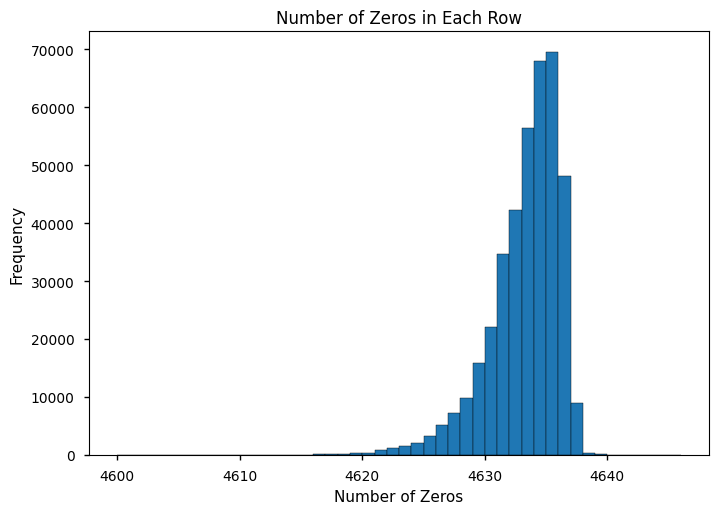

In [223]:
# Create a boolean mask where each element is True if it's equal to 0, otherwise False
zero_mask = (feature_set_with_genres == 0)

# Sum the True values (zeros) for each row
zero_count_per_row = zero_mask.sum(axis=1)

# Filter rows within the specified range
filtered_rows = zero_count_per_row[(zero_count_per_row >= 4600) & (zero_count_per_row <= 4646)]

# Plot a histogram
plt.hist(filtered_rows, bins=range(4600, 4647), edgecolor='black')
plt.title('Number of Zeros in Each Row')
plt.xlabel('Number of Zeros')
plt.ylabel('Frequency')
plt.show()

In [224]:
# Create a boolean mask where each element is True if it's equal to 0, otherwise False
zero_mask = (feature_set_with_genres == 0)

# Sum the True values (zeros) for each row
zero_count_per_row = zero_mask.sum(axis=1)

# Find rows with exactly 4600 zeros
rows_with_4600_zeros = feature_set_with_genres[zero_count_per_row == 4600]

first_5_rows_with_4600_zeros = rows_with_4600_zeros.head()

print(first_5_rows_with_4600_zeros)

       danceability  energy  loudness  speechiness  acousticness   
82552      0.596367   0.785  0.819403     0.166151      0.161647  \

       instrumentalness  liveness  valence     tempo  popularity  ...   
82552               0.0     0.126    0.785  0.430236        0.69  ...  \

      zim_hip_hop  zim_urban_groove  zimdancehall  zither  zolo  zouglou   
82552           0                 0             0       0     0        0  \

       zouk  zouk_riddim  zurich_indie  zydeco  
82552     0            0             0       0  

[1 rows x 4647 columns]


In [225]:
# Create a boolean mask where each element is True if it's equal to 0, otherwise False
zero_mask = (feature_set_with_genres == 0)

# Sum the True values (zeros) for each column
zero_count_per_column = zero_mask.sum(axis=0)

# Find columns with the most rows containing zeros
columns_with_most_zeros = zero_count_per_column[zero_count_per_column == zero_count_per_column.max()]

# Display the result
print(columns_with_most_zeros)

# Drop them!
df_without_most_zeros = feature_set_with_genres.drop(columns=columns_with_most_zeros.index)

abstract_idm             398363
acidcore                 398363
acoustic_guitar_cover    398363
african_experimental     398363
african_metal            398363
                          ...  
yiddish_folk             398363
yuri                     398363
zambian_hip_hop          398363
zen                      398363
zim_hip_hop              398363
Length: 303, dtype: int64


In [226]:
# Calculate memory usage for each column
memory_usage_per_column = df_without_most_zeros.memory_usage(deep=True)

# Get the sum of memory usage for all columns
total_memory_usage = memory_usage_per_column.sum()

# Display the result
print(f"Total memory usage: {total_memory_usage / (1024 ** 2):.2f} MB")

Total memory usage: 13229.59 MB


In [227]:
# Search for the word 'name' in column names
columns_with_name = df_without_most_zeros.filter(like='chinese', axis=1)

# Check if any column contains the word 'name'
if not columns_with_name.empty:
    print("Columns containing 'name':")
    print(columns_with_name)
else:
    print("No columns contain 'name'.")

Columns containing 'name':
        chinese_audiophile  chinese_classical  chinese_classical_performance   
0                        0                  0                              0  \
1                        0                  0                              0   
2                        0                  0                              0   
3                        0                  0                              0   
4                        0                  0                              0   
...                    ...                ...                            ...   
398359                   0                  0                              0   
398360                   0                  0                              0   
398361                   0                  0                              0   
398362                   0                  0                              0   
398363                   0                  0                              0   

        chin

#### Since memory usage is so high I've decided to drop some genres I do not care about

In [228]:
# List of words to check for in column names
words_to_drop = ['japan', 'chinese', 'viet', 'classical', 'brazilian', 'africa', 'russia', 'danish', 'borne', 'finnish', 'korean', 'indonesian', 'film', 'pakistan', 'india', 'bha', 'latvia', 'baltic', 'slav', 'czech', 'slova', 'greek', 'dutch', 'argentin', 'espan']

# Filter columns to drop
columns_to_drop = [col for col in df_without_most_zeros.columns if any(word in col for word in words_to_drop)]

# Drop columns
df_dropped = df_without_most_zeros.drop(columns=columns_to_drop)

In [229]:
# Calculate memory usage for each column
memory_usage_per_column = df_dropped.memory_usage(deep=True)

# Get the sum of memory usage for all columns
total_memory_usage = memory_usage_per_column.sum()

# Display the result
print(f"Total memory usage: {total_memory_usage / (1024 ** 2):.2f} MB")

Total memory usage: 11512.40 MB


#### Fraction_to_use determines how much of the dataset you want to use when making calculations.

In [230]:
# Specify the fraction of the dataframe to use (e.g., 10%)
fraction_to_use = 0.2

# Randomly sample a fraction of the rows
sampled_df = df_dropped.sample(frac=fraction_to_use, random_state=42)  # Set random_state for reproducibility

# Display information about the sampled dataframe
print(f"Original DataFrame shape: {df_dropped.shape}")
print(f"Sampled DataFrame shape: {sampled_df.shape}")

Original DataFrame shape: (398364, 3779)
Sampled DataFrame shape: (79673, 3779)


In [231]:
# Calculate memory usage for each column
memory_usage_per_column = sampled_df.memory_usage(deep=True)

# Get the sum of memory usage for all columns
total_memory_usage = memory_usage_per_column.sum()

# Display the result
print(f"Total memory usage: {total_memory_usage / (1024 ** 2):.2f} MB")

Total memory usage: 2303.09 MB


# Models for song recommendation

#### Hamming distance similarity
This function takes two rows, row1 and row2, and a list of column names, columns. It calculates the Hamming distance between the values in the specified columns of the two rows and converts it to a similarity measure by subtracting it from 1.

In [232]:
def hamming_distance_similarity(row1, row2, columns):
    distance = sum(row1[col] != row2[col] for col in columns)
    similarity = 1 - (distance / len(columns))
    return similarity

#### Tanimoto Coefficient Similarity
This function takes two rows, row1 and row2, and a list of column names, columns. It computes the Tanimoto coefficient similarity between the two rows by counting the number of differing values in the specified columns and dividing it by the total number of columns. The similarity is then obtained by subtracting this ratio from 1.

In [233]:
def tanimoto_coefficient_similarity(row1, row2, columns):
    distance = 0
    for col in columns:
        if row1[col] != row2[col]:
            distance += 1
    similarity = 1 - (distance / len(columns))
    return similarity

#### Jaccard Similarity
This function takes two sets, set1 and set2, and calculates the Jaccard similarity between them. It computes the intersection and union of the two sets and divides the size of the intersection by the size of the union to obtain the Jaccard similarity.

In [234]:
def jaccard_similarity(row1, row2, columns):
    set1 = set(row1[columns])
    set2 = set(row2[columns])
    intersection = set1.intersection(set2)
    union = set1.union(set2)
    similarity = len(intersection) / len(union)
    return similarity

#### Euclidean Distance
The Euclidean distance is a measure of the straight-line distance between two points in a multidimensional space. In this case, the function calculates the Euclidean distance between the values in the specified columns of the two rows.

In [235]:
def euclidean_distance(row1, row2, columns):
    distance = np.linalg.norm(row1[columns] - row2[columns])
    return distance

#### Cosine Similarity
Cosine similarity is a measure of similarity between two non-zero vectors in a vector space. It measures the cosine of the angle between the two vectors, indicating how similar or related they are in terms of their orientation.

In [236]:
def cosine_similarity_measure(row1, row2, columns):
    numeric_columns = [col for col in columns if isinstance(row1[col], numbers.Number) and isinstance(row2[col], numbers.Number)]
    if len(numeric_columns) == 0:
        return 0.0
    similarity = cosine_similarity(row1[numeric_columns].values.reshape(1, -1), row2[numeric_columns].values.reshape(1, -1))
    return similarity[0][0]

#### k-NN Nearest Neighbors 
The k-nearest neighbors (k-NN) algorithm is a non-parametric, instance-based machine learning algorithm used for classification and regression tasks. In this function it calculates the euclidean distance between the specified song and finds the song with the smallest distance. The difference using this model instead of the euclidean distance function above is that k-NN will compare it to multiple "neighbors"/rows while the euclidean function above will only compare between two individual rows.

In [237]:
def calculate_similarity(row1, row2, columns, similarity_measure):
    if similarity_measure == 'hamming':
        return hamming_distance_similarity(row1, row2, columns)
    elif similarity_measure == 'tanimoto':
        return tanimoto_coefficient_similarity(row1, row2, columns)
    elif similarity_measure == 'jaccard':
        return jaccard_similarity(row1, row2, columns)
    elif similarity_measure == 'euclidean':
        return euclidean_distance(row1, row2, columns)
    elif similarity_measure == 'cosine':
        return cosine_similarity_measure(row1, row2, columns)
    else:
        raise ValueError(f"Invalid similarity measure: {similarity_measure}")

def measure_similarity_time(sampled_df, index, columns):
    row = sampled_df.iloc[index]
    sampled_df_reset_index = sampled_df.reset_index(drop=True)
    sampled_df_without_input = sampled_df_reset_index.drop(index)

    similarity_measures = ['hamming', 'tanimoto', 'jaccard', 'euclidean', 'cosine']

    for measure in similarity_measures:
        start_time = time.time()
        for i, row in sampled_df_without_input.iterrows():
            similarity = calculate_similarity(row, sampled_df_without_input.iloc[i], columns, measure)
            if similarity != 1.0:
                most_similar_id = sampled_df_reset_index.loc[i, 'id']
                print(f"{measure.capitalize()} Similarity: Song id {most_similar_id}, Time: {time.time() - start_time}")
                break

    # KNN
    start_time = time.time()
    knn = NearestNeighbors(n_neighbors=2, metric='euclidean')
    knn.fit(sampled_df_without_input[columns].values)
    distances, indices = knn.kneighbors(row[columns].values.reshape(1, -1))
    most_similar_index = indices[0][1]
    most_similar_id = sampled_df_reset_index.loc[most_similar_index, 'id']
    print(f"KNN: Song id {most_similar_id}, Time: {time.time() - start_time}")

#### Results
When we use the Hamming, Tanimoto, and Jaccard functions to compare binary or categorical features, we consistently obtain similar results. This indicates that the features being compared are highly similar to each other. It's worth noting that the Jaccard similarity function stands out as the fastest among these functions suggesting that in this case it is the most effiecient model to use out of these three.

On the other hand, while the K-nearest neighbors algorithm shows super fast speed, it doesn't seem to provide accurate song recommendations based on my listening experience.  It seems that the kNN algorithm fails to capture the nuanced details required for precise song recommendations. Maybe that further manipulation of the dataset and fine-tuning of the kNN algorithm are necessary in order to better align it with my personal preferences.

In [238]:
columns_to_consider = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'popularity']
index = 0

measure_similarity_time(sampled_df, index, columns_to_consider)

Hamming Similarity: Song id 7MAJro1223MANWfzRWP2M3, Time: 6.124600410461426
Tanimoto Similarity: Song id 7MAJro1223MANWfzRWP2M3, Time: 3.0859456062316895
Jaccard Similarity: Song id 7MAJro1223MANWfzRWP2M3, Time: 3.097111463546753
Euclidean Similarity: Song id 7MAJro1223MANWfzRWP2M3, Time: 3.1278223991394043
Cosine Similarity: Song id 7MAJro1223MANWfzRWP2M3, Time: 3.135491371154785
KNN: Song id 6DFDTqHD5VGqsFeTGKag2u, Time: 0.21273112297058105
